## Немного полезных функций

In [1]:
from __future__ import division

import cv2
import matplotlib.pylab as plt
%matplotlib inline

import numpy as np

import plotly.graph_objs as go
import plotly.offline as py

from ipywidgets import interactive, HBox, VBox

def plt_bgr_image(image, inches=7):
    figure = plt.figure(figsize = (inches, inches))
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
    
def plt_norm_image(image, inches=7, vmin=0.0, vmax=1.0):
    figure = plt.figure(figsize = (inches, inches))
    plt.axis("off")
    plt.imshow(image, cmap="Greys_r", vmin=vmin, vmax=vmax)
    plt.show()


def plt_gray_image(image, inches = 7):
    figure = plt.figure(figsize = (inches, inches))
    plt.axis("off")
    plt.imshow(image, cmap='gray')
    plt.show()
    
    
def show_static_image(image):
    y_range = [0, image.shape[1] - 1]
    fig = go.Figure(
        data=go.Heatmap(
            z=image,
            colorscale="Greys",
            reversescale=True
        ),
        layout=go.Layout(
            # чтобы нумерация пикселей соответствовала нумерации opencv, развернём нумерацию по оси y:
            yaxis=dict(autorange='reversed', range=y_range),
            autosize=False,
            width=570,
            height=500,
            margin=dict(l=0, r=0, t=0, b=0)
        )
    )
    fig.show()


def plt_multiply_images(images: list, shape: tuple, title: str, titles: list):
    gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.5, hspace=0.5)
    fig, axs = plt.subplots(*shape, gridspec_kw=gridspec_kwargs)
    print(axs.shape)
    fig.suptitle(title)
    fig.set_size_inches(15, 15)

    for i in range(shape[0]):
        for j in range(shape[1]):
            if shape[0] > 1 and shape[1] > 1:
                axs[i, j].imshow(images[i * shape[1] + j], cmap="gray")
                axs[i, j].label_outer()
                axs[i, j].set_title(titles[i * shape[1] + j])
            elif shape[1] > 1:
                axs[j].imshow(images[i * shape[1] + j], cmap="gray")
                axs[j].label_outer()
                axs[j].set_title(titles[i * shape[1] + j])
            else:
                axs[i].imshow(images[i * shape[1] + j], cmap="gray")
                axs[i].label_outer()
                axs[i].set_title(titles[i * shape[1] + j])
    plt.show()
    

def get_template_f():
    arguments = [(121,121), 8.0, np.pi / 4, 10.0, 0.5, 0]
    gabor = cv2.getGaborKernel(*arguments)
    return go.FigureWidget(
        data=[
            go.Heatmap(
                z=gabor,
                colorscale='Greys',
                reversescale=True,
            )
        ],
        layout=go.Layout(
            yaxis=dict(autorange='reversed', range=[0, 120]),
            autosize=False,
            width=470,
            height=410,
            margin=dict(l=0, r=0, t=0, b=0)
        )
    ) 


def gabor_f_spectrum(ksize: tuple, sigma, theta, lambd, gamma, psi):
    gabor = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi)
    gabor_f = np.fft.fft2(gabor)
    return np.abs(np.fft.fftshift(gabor_f))


def log_gabor_f_spectrum(ksize: tuple, sigma, theta, lambd, gamma, psi):
    gabor = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi)
    gabor_f = np.fft.fft2(gabor)
    shift_gabor_f = np.fft.fftshift(gabor_f)
    return 20*np.log(np.abs(shift_gabor_f))


def get_shift_fft(image):
    shift_image_f = np.abs(np.fft.fftshift(np.fft.fft2(image)))
    return 20 * np.log(shift_image_f)


py.init_notebook_mode()

In [24]:
import sys
print(sys.version)

3.6.8 (default, Oct  9 2019, 14:04:01) 
[GCC 5.4.0 20160609]


#### Фильтр Габора
2D фильтр Габора задаётся следующей комплексно значной функцией
$$
    g(x,y) = s(x,y) \omega_{r}(x,y),
$$
где $s(x,y)$ -- комплексная синусоида (в англоязычной литературе иногда употребляется термин **carrier**),  
$\omega_{r}(x,y)$ -- 2D гауссиана (иногда употребляется термин **envelope**).
##### Косплексная синусоида
$$
    s(x, y) = e^{i (2π(u_{0} x + v_{0} y) + P)},
$$
где $u_{0}$, $v_{0}$ -- частоты, $P$ -- фаза.
##### 2D гауссиана
$$
    \omega_{r}(x, y) = K e^{-\pi(a^{2}(x - x_{0})_{r}^{2} + b^{2} (y - y_{0})_{r}^{2})},
$$
где 
$$
    (x − x_{0})_{r} = (x - x_{0}) \cos \theta + (y - y_{0}) \sin \theta,
$$
$$
    (y − y_{0})_{r} = −(x − x_{0}) \sin \theta + (y − y_{0}) \cos \theta,
$$
$K$ -- величина гауссианы, $(a, b)$ -- масштабы гауссианы, $\theta$ -- ориентация гауссианы (задаёт направление ядра по часовой стрелки). 

##### Фильтр Габора в opencv
Фильтр Габора в opencv представлен в виде вещественной части такой функции:
$$
    g(x, y; \lambda, \theta, \psi, \sigma, \gamma) = \exp\left(-\frac{x'^{2} + \gamma^{2}y'^{2}}{2 \sigma^{2}}\right) \exp\left(i\left(2\pi\frac{x'}{\lambda} + \psi\right)\right),
$$
где
$$
    x' = x\cos(\theta) + y \sin(\theta), ~~~~~~~~~~ y' = -x\sin(\theta) + y \cos(\theta).
$$  
Сигнатура функции в python:
```python
retval = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma[, psi[, ktype]])
```
Параметры:
1. ksize -- пара чисел $(a,b)$, задающие область определения фильтра: [(-a + 1) / 2: (a + 1) / 2, (-b + 1) / 2: (b + 1) / 2 ], то есть вычисляемый фильтр центруется на начало координат.
2. sigma -- стандартное отклонение гауссианы,
3. theta --	ориентация гауссианы,
4. lambd -- длина волны комплексной синусоиды,
5. gamma -- задаёт эллиптичность гауссианы,
6. psi -- фаза (значение по умолчанию: CV_PI * 0.5),
7. ktype -- тип коэффициентов Габора (CV_32F или CV_64F, значение по умолчанию: CV_32F).

# Фильтр Габора в пространственной области

#### Поварьируем стандартное отклонение гауссианы:

In [2]:
f = get_template_f()
parameters = (2, 16, 0.1)

def update_z_sigma(sigma):
    f.data[0].z = cv2.getGaborKernel((121, 121), sigma, np.pi / 4, 10.0, 0.5, 0) 

    
freq_slider = interactive(update_z_sigma, sigma=parameters)
vb = VBox((f, freq_slider))
vb.layout.align_items = 'center'
vb

    'data': [{'colorscale': [[0.0, 'rgb(255,255,255)'], [0.125,
                …

#### Поварьируем ориентацию гауссианы:

In [3]:
f = get_template_f()
parameters = (0, np.pi, 0.1)

def update_z_theta(theta):
    f.data[0].z = cv2.getGaborKernel((121, 121), 8.0, theta, 10.0, 0.5, 0) 

    
freq_slider = interactive(update_z_theta, theta=parameters)
vb = VBox((f, freq_slider))
vb.layout.align_items = 'center'
vb

    'data': [{'colorscale': [[0.0, 'rgb(255,255,255)'], [0.125,
                …

#### Длина волны:

In [4]:
f = get_template_f()
parameters = (5, 30, 0.2)

def update_z_lambda(lambd):
    f.data[0].z = cv2.getGaborKernel((121, 121), 8.0, np.pi / 4, lambd, 0.5, 0) 

    
freq_slider = interactive(update_z_lambda, lambd=parameters)
vb = VBox((f, freq_slider))
vb.layout.align_items = 'center'
vb

    'data': [{'colorscale': [[0.0, 'rgb(255,255,255)'], [0.125,
                …

#### Эллиптичность гауссианы ($\gamma = 1$ соответствует "круглой" гауссиане):

In [5]:
f = get_template_f()
parameters = (0, 2, 0.02)

def update_z_gamma(gamma):
    f.data[0].z = cv2.getGaborKernel((121, 121), 8.0, np.pi / 4, 10.0, gamma, 0) 

    
freq_slider = interactive(update_z_gamma, gamma=parameters)
vb = VBox((f, freq_slider))
vb.layout.align_items = 'center'
vb

    'data': [{'colorscale': [[0.0, 'rgb(255,255,255)'], [0.125,
                …

#### Фаза:

In [6]:
f = get_template_f()
parameters = (0, 2 * np.pi, 0.05)

def update_z_psi(psi):
    f.data[0].z = cv2.getGaborKernel((121, 121), 8.0, np.pi / 4, 10.0, 0.5, psi) 

    
freq_slider = interactive(update_z_psi, psi=parameters)
vb = VBox((f, freq_slider))
vb.layout.align_items = 'center'
vb

    'data': [{'colorscale': [[0.0, 'rgb(255,255,255)'], [0.125,
                …

# Фильтр Габора в частотной области

In [7]:
gabor = cv2.getGaborKernel((121,121), 4, np.pi/4, 10.0, 0.5, 0)
gabor_f = np.fft.fft2(gabor)
shift_gabor_f = np.fft.fftshift(gabor_f)
magnitude_gabor_f = np.abs(shift_gabor_f)

show_static_image(magnitude_gabor_f)

#### Можно посмотреть на изображение в логарифмических величинах.

In [8]:
log_magnitude_gabor_f = np.log(np.abs(shift_gabor_f))
show_static_image(log_magnitude_gabor_f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log



#### Ориентация гауссианы

In [9]:
f = get_template_f()
parameters = (-np.pi, np.pi, 0.1)

def update_z_theta(theta):
    f.data[0].z = gabor_f_spectrum((121, 121), 8.0, theta, 10.0, 0.5, 0) 

    
freq_slider = interactive(update_z_theta, theta=parameters)
vb = VBox((f, freq_slider))
vb.layout.align_items = 'center'
vb

    'data': [{'colorscale': [[0.0, 'rgb(255,255,255)'], [0.125,
                …

#### Стандартное отклонение гауссианы

In [10]:
f = get_template_f()
parameters = (2, 16, 0.1)

def update_z_sigma(sigma):
    f.data[0].z = gabor_f_spectrum((121, 121), sigma, np.pi / 4, 10.0, 0.5, 0) 

    
freq_slider = interactive(update_z_sigma, sigma=parameters)
vb = VBox((f, freq_slider))
vb.layout.align_items = 'center'
vb

    'data': [{'colorscale': [[0.0, 'rgb(255,255,255)'], [0.125,
                …

### Связь между между длиной волны и частотой.

В частотной области "расстояние" от начала координат до центра ядра фильтра Габора соответствует пространственной частоте $F_{0} = \sqrt{u_{0}^{2} + v_{0}^{2}}$, которая связана с длиной волны следующим образом:
$$
    F_{0} = \frac{N}{\lambda},
$$
где $N$ -- размеры ядра фильтра.

<img src="F0.png"
     style="float: left; margin-right: 10px;" />

#### Поварьируем частоту:

In [11]:
f = get_template_f()
parameters = (0.1, 50, 0.1)

def update_z_frequency(frequency):
    f.data[0].z = gabor_f_spectrum((121, 121), 8.0, np.pi / 4, (1.0 / frequency) * 121.0, 0.5, 0) 

    
freq_slider = interactive(update_z_frequency, frequency=parameters)
vb = VBox((f, freq_slider))
vb.layout.align_items = 'center'
vb

    'data': [{'colorscale': [[0.0, 'rgb(255,255,255)'], [0.125,
                …

#### Эллиптичность гауссианы

In [12]:
f = get_template_f()
parameters = (0, 2, 0.02)

def update_z_gamma(gamma):
    f.data[0].z = gabor_f_spectrum((121, 121), 8.0, np.pi / 4, 10.0, gamma, 0) 

    
freq_slider = interactive(update_z_gamma, gamma=parameters)
vb = VBox((f, freq_slider))
vb.layout.align_items = 'center'
vb

    'data': [{'colorscale': [[0.0, 'rgb(255,255,255)'], [0.125,
                …

#### Фаза

In [13]:
f = get_template_f()
parameters = (0, 2 * np.pi, 0.05)


def update_z_psi(psi):
    f.data[0].z = gabor_f_spectrum((121, 121), 8.0, np.pi / 4, 10.0, 0.5, psi) 

freq_slider = interactive(update_z_psi, psi=parameters)
vb = VBox((f, freq_slider))
vb.layout.align_items = 'center'
vb

    'data': [{'colorscale': [[0.0, 'rgb(255,255,255)'], [0.125,
                …

# Применение фильтров Габора к изображениям

#### Для начала построим 2 модельных изображения

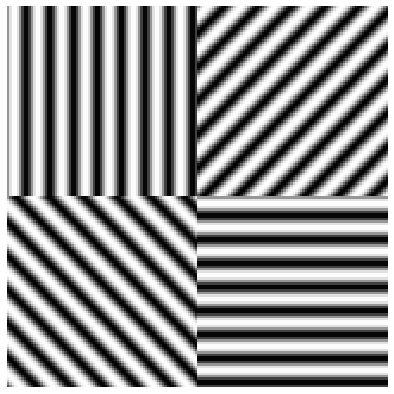

In [14]:
def make_model_image(size, period):
    x = np.arange(0.0, size, 1.0) / period * 2 * np.pi 
    y = np.arange(0.0, size, 1.0) / period * 2 * np.pi
    sin_x = np.sin(x)
    first_part = np.stack([sin_x for i in range(size)], axis = 0)
    xx, yy = np.meshgrid(x, y, sparse=True)
    second_part = np.sin(np.dot(1 / 2**0.5, xx) + np.dot(1 / 2**0.5, yy))
    third_part = np.stack([sin_x for i in range(size)], axis = 1)
    fourth_part = np.sin(np.dot(-1 / (2**0.5), xx) + np.dot(1 / 2**0.5, yy))
    return np.vstack([np.hstack([first_part, second_part]), np.hstack([fourth_part, third_part])]) / 2.0 + 1.0 / 2.0

model_image = make_model_image(80, 10).astype(np.float32)   
plt_norm_image(model_image, inches=7, vmin=0.0, vmax=1.0)

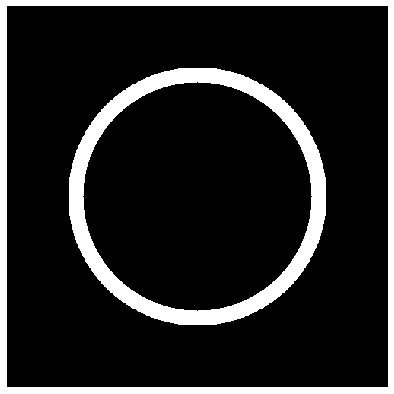

In [15]:
def make_model_circle(size, width, r):
    x = np.arange(0.0, size, 1.0)
    y = np.arange(0.0, size, 1.0)
    image = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            if np.abs(((i - center)**2 + (j - center)**2)**0.5 - r) < width:
                image[i][j] = 1.0
    return image


model_circle = make_model_circle(501, 10, 160).astype(np.float32)   
plt_norm_image(model_circle, inches=7, vmin=0.0, vmax=1.0)

### Определим функции для построения банка фильтров Габора

In [16]:
def build_filters(ksize, sigma, thetas, lambdas, gamma, psi):
    filters = []
    titles = []
    for theta in thetas:
        for lambd in lambdas: 
            kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
            kern /= np.sqrt((kern * kern).sum()) # нормируем на L2-норму
            filters.append(kern)
            titles.append("thet={:.2f},lamb={:.2f}".format(theta, lambd))
    return (filters, titles)

    
def process(img, filters):
    res = []
    for kern in filters:
        fimg = cv2.filter2D(img, -1, kern)
        normalized_fimg = cv2.normalize(fimg, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        res.append(normalized_fimg)
    return res


def process_single(img, kern):
    fimg = cv2.filter2D(img, -1, kern)
    return cv2.normalize(fimg, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

### Немного про cv2.filtered2D
```python
cv2.filter2D(src, ddepth, kernel[, dst[, anchor[, delta[, borderType]]]]) → dst
```
Параметры:	
1. src – изображение к которому применяется фильтр,
2. ddepth – "глубина" итогового результата (скорее тип -- dtype), если ddepth == -1, то тип будет таким же как у исходного изображения, 
Поддерживаются следующие комбинации:
src.depth() = CV_8U, ddepth = -1/CV_16S/CV_32F/CV_64F
src.depth() = CV_16U/CV_16S, ddepth = -1/CV_32F/CV_64F
src.depth() = CV_32F, ddepth = -1/CV_32F/CV_64F
src.depth() = CV_64F, ddepth = -1/CV_64F,

3. kernel – ядро преобразования (одноканальная матрицf типа cv2.CV_64F или cv2.CV_32F) (если хочется применять разные преобразования для разных каналов исходного изображения, то необходимо сделать "split" и работать с каждым каналом отдельно,
4. anchor – "якорь" ядра, он обозначает позицию ядра относительно, точки в котором вычисляется преобразование (по умолчанию (-1, -1), что соответствует центру фильтра,
5. delta – опциональный аргумент, задающий сдвиг, который добавляется ко всем пикселям преобразованного изображения.
6. borderType – элемент перечисления [enum BorderTypes](https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/enum_cv_BorderTypes.html#doxid-d2-de8-group-core-array-1gga209f2f4869e304c82d07739337eae7c5aa1de4cff95e3377d6d0cbe7569bd4e9f), задающий способ заполнения границ (по умолчанию BORDER_DEFAULT, который соответствует отражению: gfedcb|abcdefgh|gfedcba)

[Чуть подробнее](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#filter2d)

### Пименим фильтры Габора к модельным изображениям

In [17]:
ksize = 21
sigma = 4.0
thetas = np.arange(0, np.pi, np.pi / 4)
lambdas = [20.0, 15.0, 6.67, 2.85]
gamma = 0.5
psi = 0

filters, titles = build_filters(ksize, sigma, thetas, lambdas, gamma, psi)

plt_multiply_images(filters, (4, 4), "Filters.", titles)

(4, 4)


(4, 4)


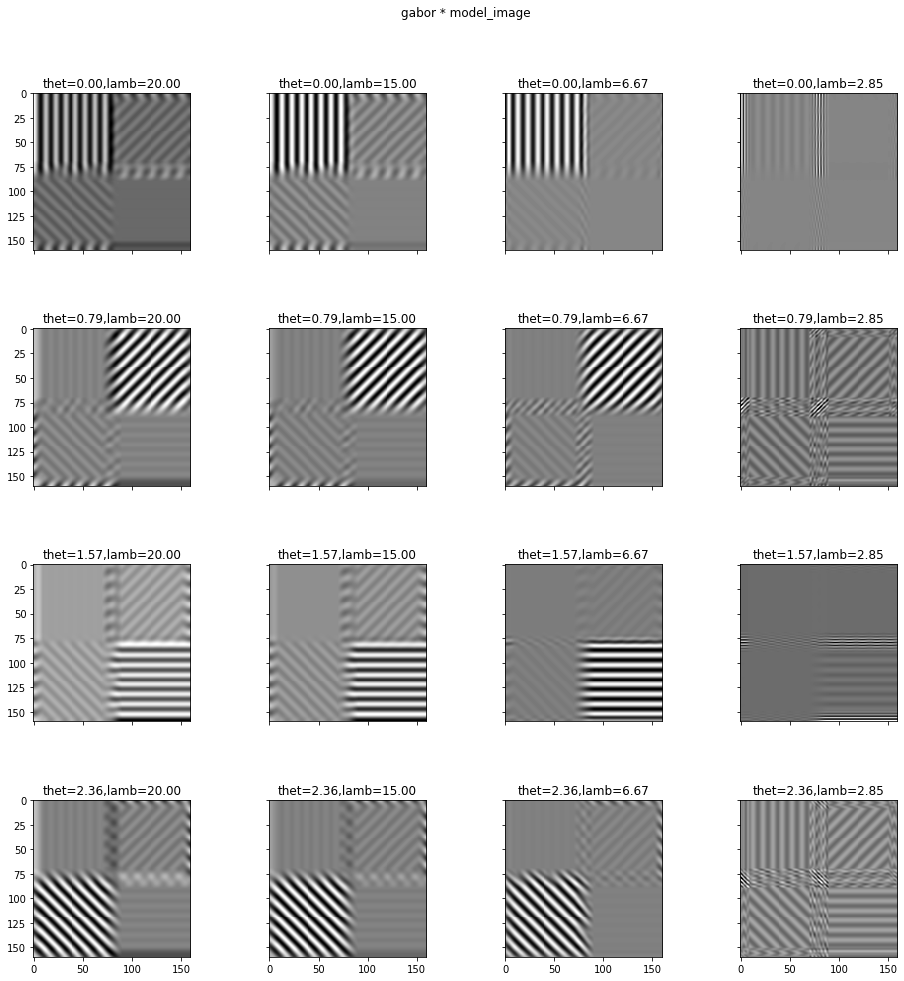

In [18]:
res = process(model_image, filters)
plt_multiply_images(res, (4, 4), "gabor * model_image", titles)

(4, 4)


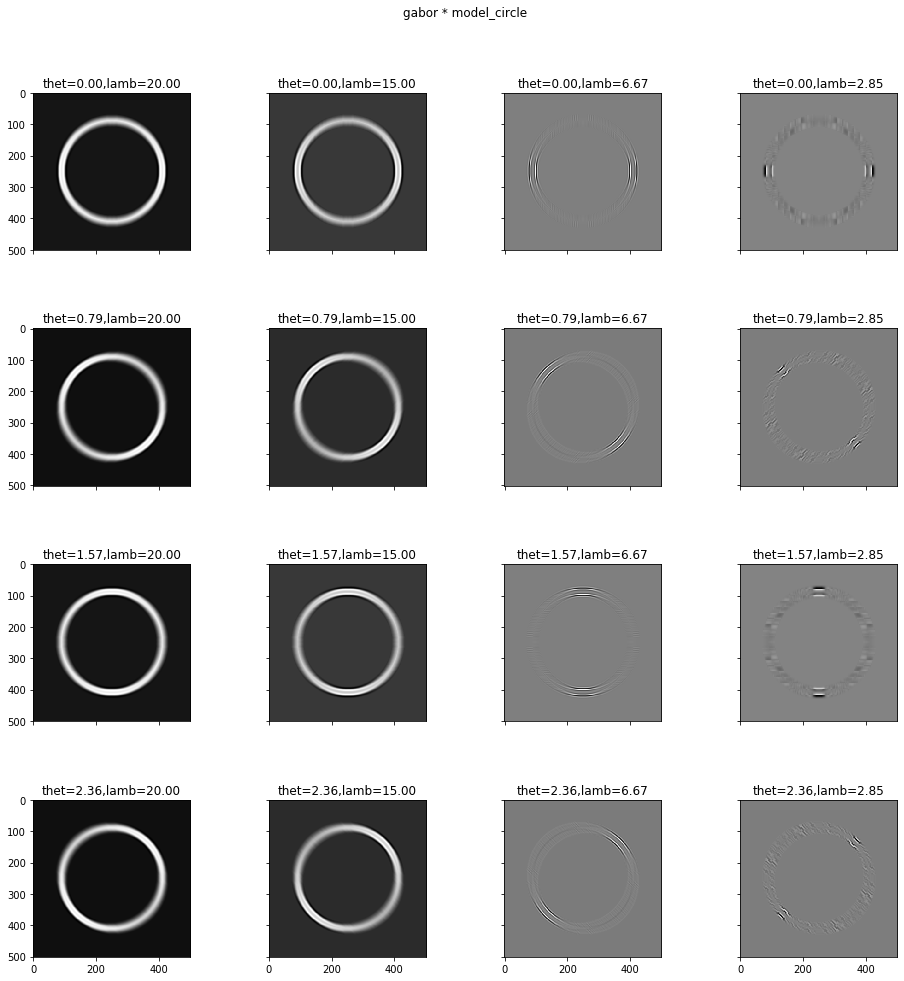

In [19]:
res = process(model_circle, filters)
plt_multiply_images(res, (4, 4), "gabor * model_circle", titles)

### Загрузим чуть более реальное изображение.

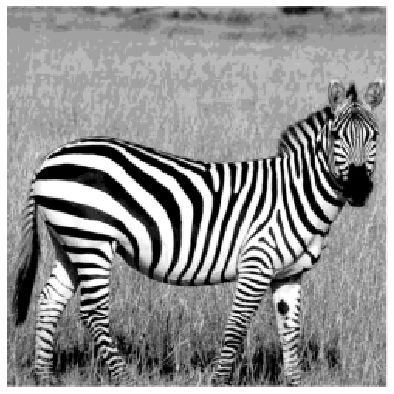

In [20]:
zebra = cv2.imread("zebra_small.png", cv2.IMREAD_GRAYSCALE)

normalized_zebra = cv2.normalize(zebra, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt_norm_image(normalized_zebra, inches=7, vmin=0.0, vmax=1.0)

In [21]:
ksize = 21
sigma = 4.0
thetas = np.arange(0, np.pi, np.pi / 4)
lambdas = [10.0, 6.67, 2.85]
gamma = 0.5
psi = 0

filters, titles = build_filters(ksize, sigma, thetas, lambdas, gamma, psi)

res = process(normalized_zebra, filters)
plt_multiply_images(res, (4, 3), "gabor * zebra", titles)

(4, 3)


In [22]:
ksize = 21
sigma = 4.0

lambd = 6.67
gamma = 0.5
psi = 0

gabor = cv2.getGaborKernel((ksize,ksize), sigma, 0.0, lambd, gamma, psi)
gabor /= np.sqrt((gabor * gabor).sum())
f = go.FigureWidget(
    data=[
        go.Heatmap(
            z=np.log(255 * process_single(zebra, gabor) + 1),
            colorscale='Greys',
            reversescale=True,
        )
    ],
    layout=go.Layout(
        yaxis=dict(autorange='reversed'),
        autosize=False,
        width=470,
        height=410,
        margin=dict(l=0, r=0, t=0, b=0)
    )
)

parameters = (0, np.pi, 0.1)

def update_z_theta(theta):
    gabor = cv2.getGaborKernel((ksize,ksize), sigma, theta, lambd, gamma, psi)
    gabor /= (gabor * gabor).sum()
    f.data[0].z = np.log(255 * process_single(zebra, gabor) + 1)

    
freq_slider = interactive(update_z_theta, theta=parameters)
vb = VBox((f, freq_slider))
vb.layout.align_items = 'center'
vb

    'data': [{'colorscale': [[0.0, 'rgb(255,255,255)'], [0.125,
                …

### Список ресурсов:
1. [Tutorial on Gabor Filters by Javier R. Movellan](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.370.3513&rep=rep1&type=pdf)
2. [Machine learning for image classification Lecture 8 by Anne Solberg Department of Informatics University of Oslo](https://www.uio.no/studier/emner/matnat/ifi/INF5860/v17/undervisningsmateriale/inf5860_lecture8.pdf)
3. [Пример обработки изображения круга фильтрами Габора](https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97)
4. [Фильтр Габора для обработки изображения лиц](http://earchive.tpu.ru/bitstream/11683/17335/1/conference_tpu-2015-C24-090.pdf)
5. [Multi Image в Matplotlib](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/multi_image.html)
6. [Реверсивные шкалы цветов в Matplotlib](https://matplotlib.org/api/pyplot_summary.html?highlight=colormaps#matplotlib.pyplot.colormaps)
7. [Документация cv2.filter2D](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#filter2d)
8. [Типы заполнения границы при фильтрации](https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/enum_cv_BorderTypes.html#doxid-d2-de8-group-core-array-1gga209f2f4869e304c82d07739337eae7c5aa1de4cff95e3377d6d0cbe7569bd4e9f)
9. [Нормализация в opencv](https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize)
10. [Интерактивные графики в plotly](https://plot.ly/python/)
11. [Heatmaps in plotly](https://plot.ly/python/heatmaps/)
11. [Cлайдеры в plotly](https://plot.ly/python/slider-widget/)